<a href="https://colab.research.google.com/github/hc011/Music-generation-using-LSTM/blob/main/Music_generation_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter #counter dictionary for key and count unique mapping
import random
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split #splits training and test data
from tensorflow.keras.models import Sequential #creation of layer stack
from tensorflow.keras.layers import LSTM, Dense, Dropout 
import tensorflow.keras.backend as K 
from tensorflow.keras.optimizers import Adamax
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #add shapes in plots
%matplotlib inline
import sys
import warnings
import os
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42) #random number generator



In [ ]:
#load and parse data
filepath="/content/drive/MyDrive/midi/beethoven/"
midis=[] #list of scores of individual training midi files
for i in os.listdir(filepath):
  if i.endswith(".mid"):
    single_midi_location=filepath+i
    midi=converter.parse(single_midi_location) #musical score is returned
    midis.append(midi)

NotADirectoryError: ignored

In [ ]:
import pickle
with open('/content/drive/MyDrive/midisparsed.pickle','rb') as g:
  data=pickle.load(g)

In [ ]:
print(data)

[<music21.stream.Score 140010955892112>, <music21.stream.Score 140010940608848>, <music21.stream.Score 140010945903568>, <music21.stream.Score 140010926032336>, <music21.stream.Score 140010921890192>, <music21.stream.Score 140010921759184>, <music21.stream.Score 140010910428304>, <music21.stream.Score 140010889184976>, <music21.stream.Score 140010884977040>, <music21.stream.Score 140010884139152>, <music21.stream.Score 140010870914384>, <music21.stream.Score 140010873595536>, <music21.stream.Score 140010925896592>, <music21.stream.Score 140010876717520>, <music21.stream.Score 140010821679248>, <music21.stream.Score 140010874864592>, <music21.stream.Score 140010804232656>, <music21.stream.Score 140010787740688>, <music21.stream.Score 140010871529040>, <music21.stream.Score 140010690978512>, <music21.stream.Score 140010779286224>, <music21.stream.Score 140010705429520>, <music21.stream.Score 140010651054800>, <music21.stream.Score 140010763365200>, <music21.stream.Score 140010751062416>,

In [ ]:
#get the notes from the score
       
def extract_notes(file):
    notes = []
    pick=None
    for j in file:
        songs = instrument.partitionByInstrument(j)#
        if songs is not None:
          for part in songs.parts:
              pick = part.recurse() #single element(note or chord) in score
              for element in pick:
                  if isinstance(element, note.Note): #check if it is note
                      notes.append(str(element.pitch))
                  elif isinstance(element, chord.Chord): #check if it is chord
                      notes.append(".".join(str(n) for n in element.normalOrder)) #divides the chord in notes and appends each in notes
    return notes

corpus=extract_notes(data)

KeyboardInterrupt: ignored

In [ ]:
import pickle
with open('/content/drive/MyDrive/midicorpus.pickle','rb') as i:
  corpus=pickle.load(i)

In [ ]:
print(len(corpus))

105463


In [ ]:
print(corpus[0:40])

['7.11', '9.0', '11.2', 'G2', '10.1', '11.2', 'B2', '10.1', '11.2', 'D3', '10.1', '11.2', 'G3', 'G2', '0.4', '8.11', '9.0', 'D3', 'D2', '11.2', '6.9', '7', 'B4', 'G1', '7.11', '9.2', '7.11', 'G2', '6.10', '7.11', 'B2', '6.10', '7.11', 'E-3', '6.10', '7.11', 'E3', 'F#3', '6.9', 'G3']


In [ ]:
#To show musical score
def chords_n_notes(Snippet):
    Melody = []
    offset = 2 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi
Melody_Snippet = chords_n_notes(corpus[0:100])

In [ ]:
count_num=Counter(corpus)
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Total unique notes in the Corpus:", len(count_num))
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Total unique notes in the Corpus: 300
Average recurrenc for a note in Corpus: 351.54333333333335
Most frequent note in Corpus appeared: 2832 times
Least frequent note in Corpus appeared: 1 time


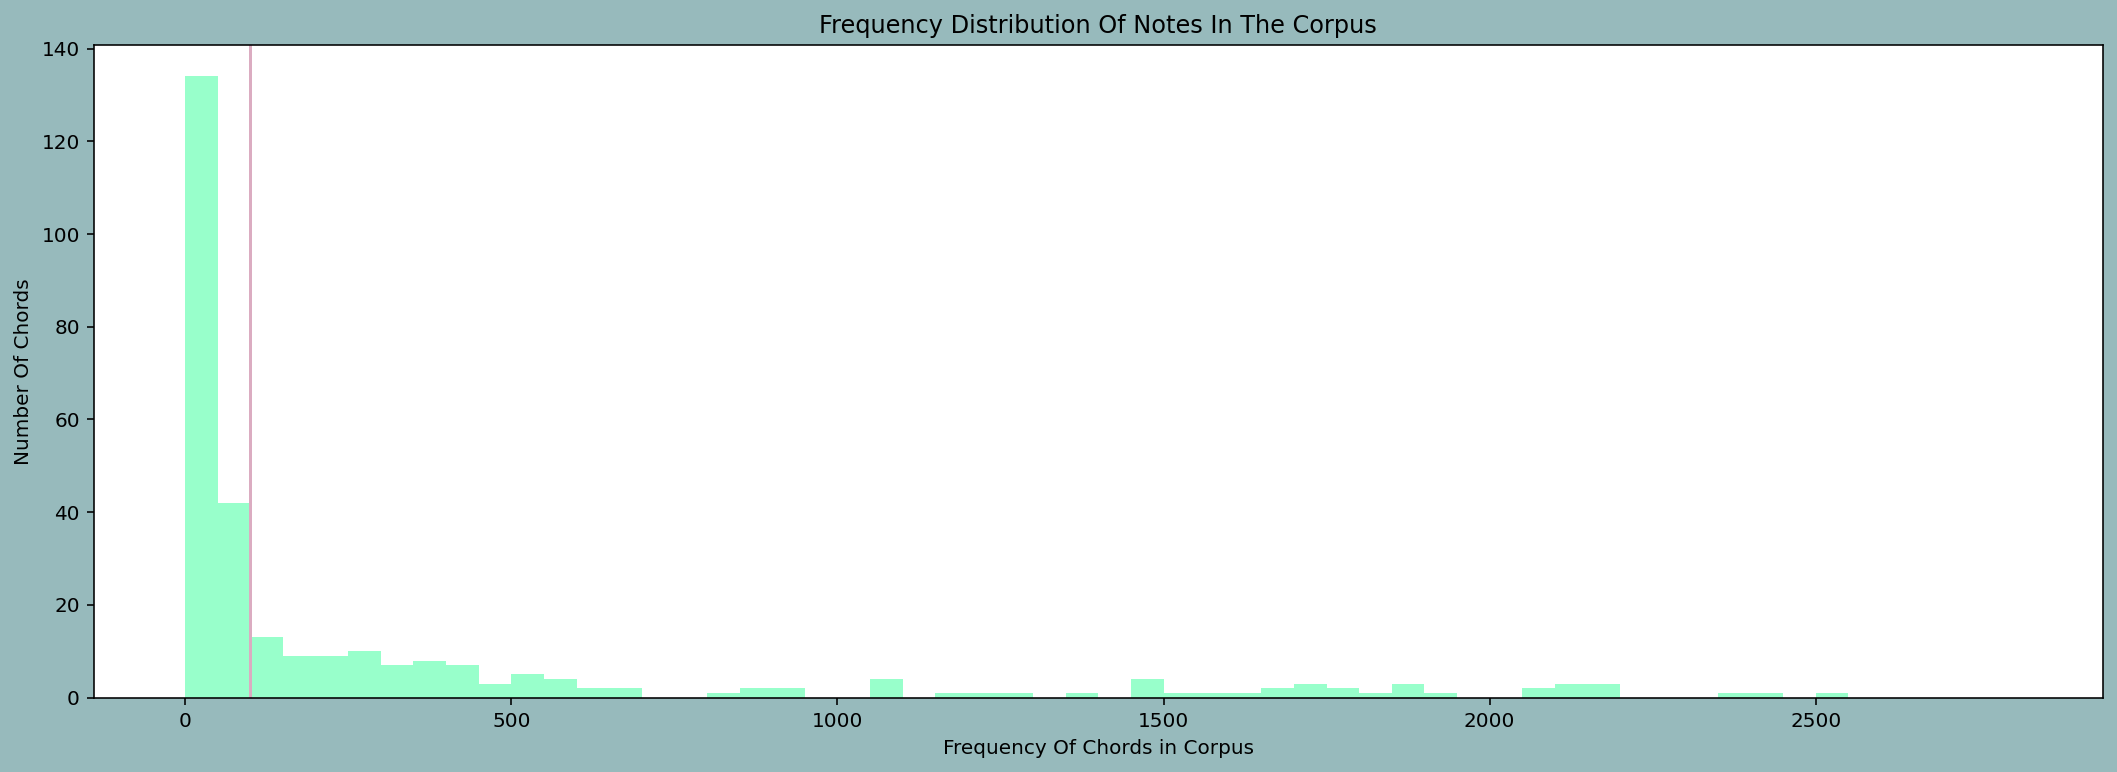

In [ ]:
plt.figure(figsize=(18,6),facecolor="#97BABC")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#98FFCB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [ ]:
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 176


In [ ]:
# Storing all the unique characters present in my corpus to build a mapping dic. 
symb = sorted(list(set(corpus)))

L_corpus = len(corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 105463
Number of unique characters: 300


In [ ]:
print(mapping)
print(reverse_mapping)

{'0': 0, '0.1': 1, '0.1.3': 2, '0.1.3.6.8': 3, '0.2': 4, '0.2.5': 5, '0.2.5.7': 6, '0.2.5.8': 7, '0.2.6': 8, '0.2.6.7': 9, '0.3': 10, '0.3.5': 11, '0.3.5.8': 12, '0.3.6': 13, '0.3.6.8': 14, '0.3.6.9': 15, '0.3.7': 16, '0.4': 17, '0.4.5': 18, '0.4.6': 19, '0.4.7': 20, '0.4.8': 21, '0.5': 22, '0.6': 23, '1': 24, '1.2': 25, '1.2.5.8': 26, '1.3': 27, '1.3.4.7': 28, '1.3.5': 29, '1.3.6': 30, '1.3.6.8': 31, '1.3.6.9': 32, '1.3.7': 33, '1.3.7.8': 34, '1.3.8': 35, '1.4': 36, '1.4.6': 37, '1.4.7': 38, '1.4.7.10': 39, '1.4.7.9': 40, '1.4.8': 41, '1.5': 42, '1.5.7': 43, '1.5.8': 44, '1.6': 45, '1.7': 46, '10': 47, '10.0': 48, '10.0.3': 49, '10.0.3.6': 50, '10.0.4': 51, '10.0.5': 52, '10.1': 53, '10.1.3': 54, '10.1.3.6': 55, '10.1.4': 56, '10.1.4.6': 57, '10.1.5': 58, '10.11.3.6': 59, '10.2': 60, '10.2.3': 61, '10.2.3.5': 62, '10.2.5': 63, '10.3': 64, '11': 65, '11.0': 66, '11.0.2': 67, '11.0.2.5.7': 68, '11.1': 69, '11.1.2': 70, '11.1.5': 71, '11.2': 72, '11.2.3': 73, '11.2.4': 74, '11.2.4.6': 75

In [ ]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = [] #integer map of each element
targets = [] #reverse integer map of each integer
for i in range(0, L_corpus - length, 1):
    feature = corpus[i:i + length]#batch of 40 elements, a b
    target = corpus[i + length]#note/chord after above 40 elements, c
    features.append([mapping[j] for j in feature])#appending integer mapped to each element
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences of consecutive 40 elements in the Corpus:", L_datapoints)

Total number of sequences of consecutive 40 elements in the Corpus: 105423


In [ ]:
# reshape X,y and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

In [ ]:
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Initialising the Model
import tensorflow as tf

model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               77100     
                                                                 
Total params: 1,983,020
Trainable params: 1,983,020
No

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

In [ ]:
#importing save trained model
import joblib
model = joblib.load('/content/drive/MyDrive/modelfinal.pkl')


In [ ]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi
Music_notes, Melody = Malody_Generator(100)

In [ ]:
#To save the generated melody

Melody.write('midi','Generated_melody.mid')


'Generated_melody.mid'